# Imports 

In [1]:
import os
import sys
from glob import glob

astropylibdir = None
for dr in glob('/home/eriktollerud/src_win/astropy/build/lib.*'):
    if '{0.major}.{0.minor}'.format(sys.version_info) in os.path.split(dr)[-1]:
        if astropylibdir is not None:
            print('Found *another* astropy lib dir:', dr, 'sticking with first:', astropylibdir)
        else:
            astropylibdir = dr
if astropylibdir is None:
    print('Did not find an astropy lib dir, using whatever is already installed')
else:
    sys.path.insert(0, astropylibdir)

import astropy
astropy

<module 'astropy' from '/home/eriktollerud/src_win/astropy/build/lib.linux-x86_64-3.5/astropy/__init__.py'>

In [2]:
from astropy import units as u
from astropy import coordinates as acoo
from astropy import table
from astropy.time import Time
from astropy import constants as cnst

In [3]:
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt

# Code

In [4]:
from astropy.coordinates import *

In [5]:
def diff_info_plot(frame, time):
    
    fig, ((ax1, ax2), (ax3,ax4)) = plt.subplots( 2, 2, figsize=(20, 12))
    ax1.plot_date(time.plot_date, frame.data.differentials[0].d_xyz.to(u.km/u.s).T, fmt='-')
    ax1.legend(['x', 'y', 'z'])

    ax2.plot_date(time.plot_date, np.sum(frame.data.differentials[0].d_xyz.to(u.km/u.s)**2,axis=0)**0.5, fmt='-')
    ax2.set_title('total')


    sd = frame.data.differentials[0].represent_as(SphericalDifferential, frame.data)

    ax3.plot_date(time.plot_date, sd.d_distance.to(u.km/u.s), fmt='-')
    ax3.set_title('radial')


    ax4.plot_date(time.plot_date, sd.d_lat.to(u.marcsec/u.yr), fmt='-', label='lat')
    ax4.plot_date(time.plot_date, sd.d_lon.to(u.marcsec/u.yr), fmt='-', label='lon')
    
    return fig

29.416124335482234 km / s
29.40707269710233 km / s
119.41147850923613 km / s
820.1747559910588 km / s


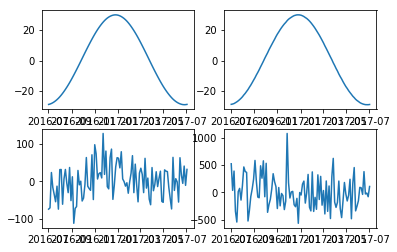

In [61]:
time = Time('J2017') + np.linspace(-.5, .5, 100)*u.year
    
fig, axs = plt.subplots(2, 2)
for d, ax in zip([1000*u.au, 10*u.pc, 10*u.kpc, 100*u.kpc], axs.ravel()):
    icoo = ICRS(ra=0*u.deg, dec=10*u.deg, distance=d,
                pm_ra=0*u.marcsec/u.yr, pm_dec=0*u.marcsec/u.yr,
                radial_velocity=0*u.km/u.s)
    gcoo = icoo.transform_to(GCRS(obstime=time))
    rv =  gcoo.radial_velocity.to('km/s')
    ax.plot_date(time.plot_date, rv, fmt='-')
    print(np.ptp(rv)/2)

In [6]:
time = Time('J2017')
gf = GCRS(obstime=time)
sung = get_sun(time)  # should have very little vhelio

# qtr-year off sun location should be the direction of ~ maximal vhelio
qtrsung = get_sun(time-.25*u.year)

#now we use those directions to
msungr = CartesianRepresentation(-sung.cartesian.xyz).represent_as(SphericalRepresentation)
suni = ICRS(ra=msungr.lon, dec=msungr.lat, distance=1000*u.au,
            pm_ra=0*u.marcsec/u.yr, pm_dec=0*u.marcsec/u.yr,
            radial_velocity=0*u.km/u.s)
qtrsuni = ICRS(ra=qtrsung.ra, dec=qtrsung.dec, distance=1000*u.au,
               pm_ra=0*u.marcsec/u.yr, pm_dec=0*u.marcsec/u.yr,
               radial_velocity=0*u.km/u.s)
sung = suni.transform_to(gf)
qtrsung = qtrsuni.transform_to(gf)

assert np.abs(qtrsung.radial_velocity) > 30*u.km/u.s
assert np.abs(qtrsung.radial_velocity) < 40*u.km/u.s
assert np.abs(sung.radial_velocity) < 1*u.km/u.s
sung.radial_velocity.to(u.km/u.s), qtrsung.radial_velocity.to(u.km/u.s)

initial [ 0.  0.  0.] km / s
induced [ 29.81708632   4.97521609   2.15613559] km / s
initial [ 0.  0.  0.] km / s
induced [ 30.26469318   2.18259471   0.94558724] km / s


(<Quantity 0.019076467966981855 km / s>, <Quantity -30.28391534690356 km / s>)

In [31]:
sung = suni.transform_to(gf)
suni2 = sung.transform_to(ICRS)
suni2.data.differentials[0].d_xyz.to('km/s')

initial [ 0.  0.  0.] km / s
induced [ 29.81065968   4.97434234   2.15514492] km / s
initial [ 29.81120179   4.97157652   2.15394484] km / s
induced [-29.81120658  -4.97158077  -2.15394909] km / s


<Quantity [ -4.78330561e-06, -4.25182721e-06, -4.25182721e-06] km / s>

In [8]:
dt = 1*u.second
fwd = suni.transform_to(GCRS(obstime=sung.obstime + dt/2))
back = suni.transform_to(GCRS(obstime=sung.obstime - dt/2))

res1 = ((fwd.data.without_differentials() - back.data.without_differentials()).to_cartesian()/dt).xyz.to('km/s')
res1

initial [ 0.  0.  0.] km / s
induced [ 29.81712459   4.97519908   2.15611859] km / s
initial [ 0.  0.  0.] km / s
induced [ 29.81709057   4.97518207   2.15613559] km / s


<Quantity [ 29.81708632,  4.97521609,  2.15613559] km / s>

In [9]:
dt = 1*u.second
fwd = sung.replicate(obstime=sung.obstime + dt/2).transform_to(ICRS)
back = sung.replicate(obstime=sung.obstime - dt/2).transform_to(ICRS)

res2 = ((fwd.data.without_differentials() - back.data.without_differentials()).to_cartesian()/dt).xyz.to('km/s')
res2

initial [ 29.81765181   4.97242689   2.15493658] km / s
induced [-29.81765607  -4.97240988  -2.15491957] km / s
initial [ 29.81765607   4.97242689   2.15493658] km / s
induced [-29.81765181  -4.9724439   -2.15490256] km / s


<Quantity [-29.81768583, -4.97242689, -2.15493658] km / s>

In [10]:
res2+res1

<Quantity [-0.00059951, 0.0027892 , 0.00119902] km / s>

In [11]:
qtrsung.data.differentials[0].d_xyz.to(u.km/u.s)

<Quantity [ 30.26469318,  2.18259471,  0.94558724] km / s>

In [12]:
sung.data.differentials[0].d_xyz.to(u.km/u.s)

<Quantity [ 29.81708632,  4.97521609,  2.15613559] km / s>

In [29]:
qtrsuni2.data.differentials[0].d_xyz

NameError: name 'qtrsuni2' is not defined

In [13]:
#assert qtrsuni2.data.differentials[0].d_xyz < 1e-5*u.km/u.s
#assert suni2.transform_to(ICRS).data.differentials[0].d_xyz < 1e-5*u.km/u.s

In [14]:
get_sun(time).realize_frame(suni.data).transform_to(ICRS).data.differentials[0].d_xyz.to('km/s')

initial [ 0.  0.  0.] km / s
induced [-29.8179792   -4.9724439   -2.15494508] km / s


<Quantity [-29.8179792 , -4.9724439 , -2.15494508] km / s>

In [15]:
get_sun(time).realize_frame(suni.data)

<GCRS Coordinate (obstime=J2017.000, obsgeoloc=( 0.,  0.,  0.) m, obsgeovel=( 0.,  0.,  0.) m / s): (ra, dec, distance) in (deg, deg, AU)
    ( 101.16545634,  23.0401647,  1000.)>

In [16]:
time = Time('J2017')
gf = GCRS(obstime=time)
sung = get_sun(time)  # should have very little vhelio

# qtr-year off sun location should be the direction of ~ maximal vhelio
qtrsung = get_sun(time-.25*u.year)

#now we use those directions to
msungr = CartesianRepresentation(-sung.cartesian.xyz).represent_as(SphericalRepresentation)
suni = ICRS(ra=msungr.lon, dec=msungr.lat, distance=100*u.au,
            pm_ra=0*u.marcsec/u.yr, pm_dec=0*u.marcsec/u.yr,
            radial_velocity=0*u.km/u.s)
qtrsuni = ICRS(ra=qtrsung.ra, dec=qtrsung.dec, distance=np.logspace(0, 3,100)*u.au,
               pm_ra=0*u.marcsec/u.yr, pm_dec=np.zeros(100)*u.marcsec/u.yr,
               radial_velocity=0*u.km/u.s)
sung = suni.transform_to(gf)
qtrsung = qtrsuni.transform_to(gf)

initial [ 0.  0.  0.] km / s
induced [ 29.81065968   4.97434234   2.15514492] km / s
initial [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  

In [17]:
qtrsung.radial_velocity.to(u.km/u.s)

<Quantity [-21.96307267,-22.696503  ,-23.39671926,-24.06017615,
           -24.68414584,-25.2667525 ,-25.80696367,-26.30454292,
           -26.7599729 ,-27.17435517,-27.54929928,-27.88680777,
           -28.18916495,-28.45883408,-28.69836922,-28.91033953,
           -29.09726873,-29.26158925,-29.40560963,-29.53149131,
           -29.64123633,-29.73668155,-29.81949936,-29.89120028,
           -29.95314215,-30.00653926,-30.05247145,-30.09189623,
           -30.12565967,-30.1545069 ,-30.17909259,-30.19998836,
           -30.21769869,-30.23265951,-30.24525245,-30.2558106 ,
           -30.26462008,-30.27193279,-30.27796542,-30.28290547,
           -30.28691369,-30.29013267,-30.29268025,-30.29466196,
           -30.29616644,-30.29727065,-30.29803937,-30.29853144,
           -30.29879278,-30.29886545,-30.29878354,-30.29857782,
           -30.29827197,-30.29789169,-30.29744914,-30.29696566,
           -30.29644665,-30.2959084 ,-30.29535788,-30.29480254,
           -30.29424868,-30.29369574,-30

In [18]:
sung.radial_velocity.to(u.km/u.s)

<Quantity 0.017961304008138657 km / s>

In [19]:
np.sum(sung.data.differentials[0].d_xyz.to(u.km/u.s)**2)**0.5

<Quantity 30.299573628712334 km / s>

[]

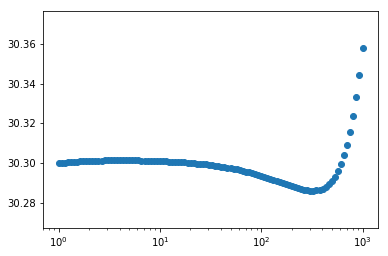

In [20]:
plt.scatter(qtrsuni.distance.value, np.sum(qtrsung.data.differentials[0].d_xyz.to(u.km/u.s)**2, axis=0)**0.5)
plt.semilogx()

[]

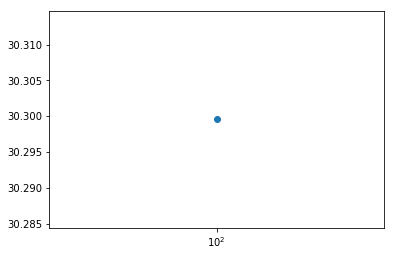

In [21]:
plt.scatter(suni.distance.value, np.sum(sung.data.differentials[0].d_xyz.to(u.km/u.s)**2, axis=0)**0.5)
plt.semilogx()

In [25]:
time = Time('J2015') + np.linspace(-1, 1, 1000)*u.day
loc = EarthLocation.of_site('greenwich')  #built-in
aa = AltAz(obstime=time, location=loc)

icoo = ICRS(np.zeros_like(time)*u.deg, 10*u.deg, 100*u.au,  
     pm_ra=np.zeros_like(time)*u.marcsec/u.yr, pm_dec=0*u.marcsec/u.yr, 
     radial_velocity=0*u.km/u.s)

acoo = icoo.transform_to(aa)

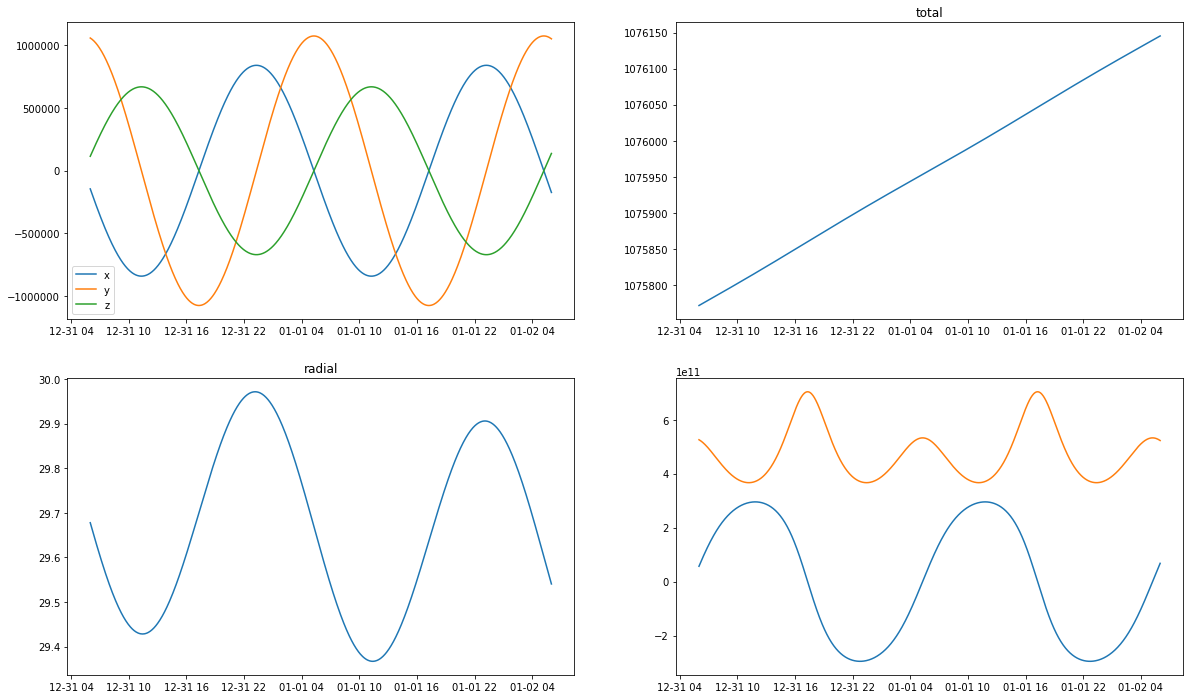

In [26]:
diff_info_plot(acoo, time);

In [28]:
np.ptp(acoo.radial_velocity)

<Quantity 604.0223031491041 m / s>

In [41]:
cdiff = acoo.data.differentials[0].represent_as(CartesianDifferential, 
                                                    acoo.data)

True

In [29]:
from astropy import constants as cnst

In [33]:
(2*np.pi*cnst.R_earth/u.day).to(u.m/u.s)

<Quantity 463.8311389165877 m / s>

initial [[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]] km / s
induced [[-28.84647495 -28.81794944 -28.78865435 ..., -28.87825736 -28.85223405
  -28.8255262 ]
 [ -4.61689807  -4.75365754  -4.89026755 ...,  -4.33271049  -4.46850675
   -4.60419376]
 [ -1.99523051  -2.05420601  -2.11311401 ...,  -1.87362931  -1.93236512
   -1.9910499 ]] km / s


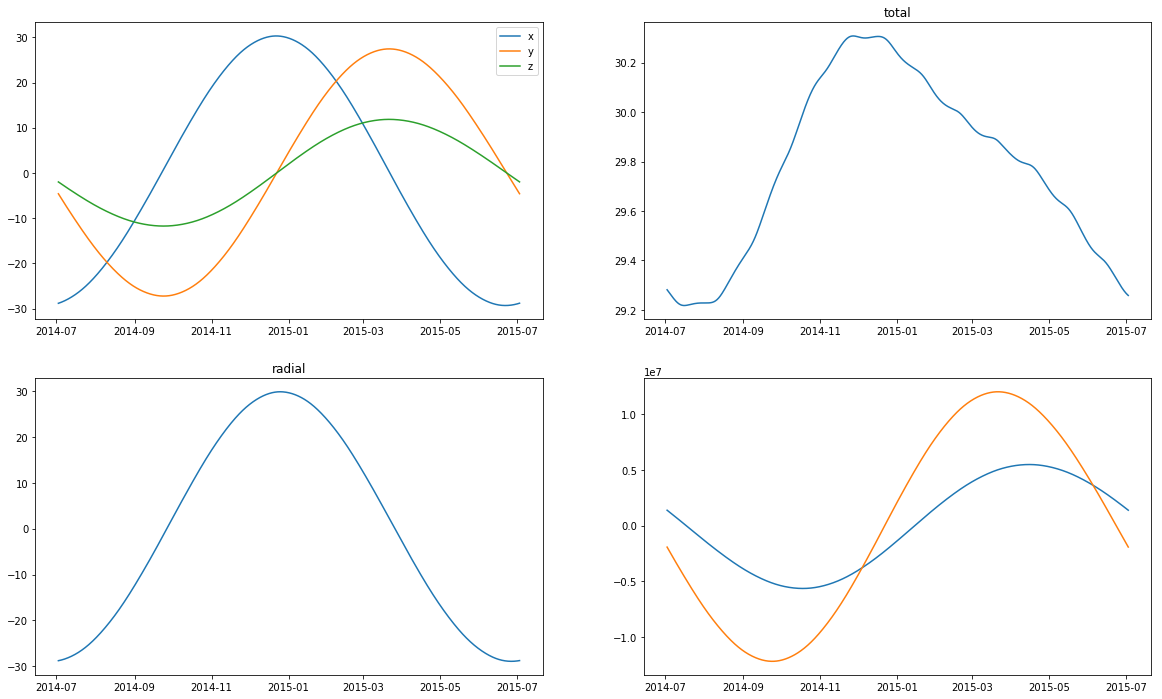

In [23]:
g = i.transform_to(GCRS(obstime=time))

fig, ((ax1, ax2), (ax3,ax4)) = plt.subplots( 2, 2, figsize=(20, 12))
ax1.plot_date(time.plot_date, g.data.differentials[0].d_xyz.to(u.km/u.s).T, fmt='-')
ax1.legend(['x', 'y', 'z'])

ax2.plot_date(time.plot_date, np.sum(g.data.differentials[0].d_xyz.to(u.km/u.s)**2,axis=0)**0.5, fmt='-')
ax2.set_title('total')


sd = g.data.differentials[0].represent_as(SphericalDifferential, g.data)

ax3.plot_date(time.plot_date, sd.d_distance.to(u.km/u.s), fmt='-')
ax3.set_title('radial')


ax4.plot_date(time.plot_date, sd.d_lat.to(u.marcsec/u.yr), fmt='-', label='lat')
ax4.plot_date(time.plot_date, sd.d_lon.to(u.marcsec/u.yr), fmt='-', label='lon')

AA1
initial [[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]] km / s
induced [[ 29.96287085  29.96260086  29.96232661 ...,  29.57135622  29.57097355
   29.57059089]
 [  3.7503692    3.75196161   3.75356714 ...,   5.65244467   5.65401499
    5.65558534]
 [  1.70358705   1.70432049   1.70505234 ...,   2.56491795   2.56560569
    2.56629714]] km / s
initial [[ 24.68006055  24.66425195  24.63806641 ...,  25.14922852  25.15198242
   25.14438477]
 [  0.67187158   1.30460205   1.93674072 ...,  -0.46138574   0.16978564
    0.80089404]
 [-17.46952734 -17.45600293 -17.43422363 ..., -16.74209473 -16.74341016
  -16.73647754]] km / s
induced [[ -130597.60391797  -148040.60325     -165418.22189648 ...,
   -152812.94586914  -170183.75610352  -187479.40339258]
 [ 1062555.63601172  1058813.19199316  1054602.99094336 ...,
   1058465.02633057  1054126.69873242  1049322.68576904]
 [  103966.20897461   117852.01959375   131685.78201465 ...,
    121651.14823926

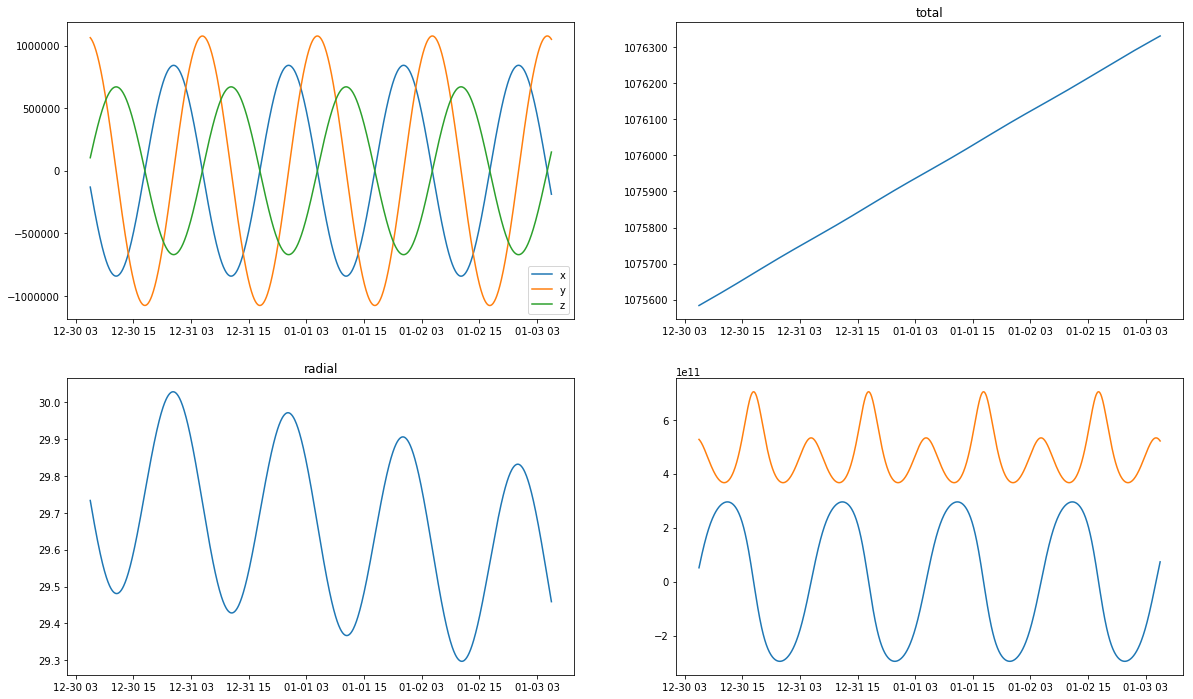

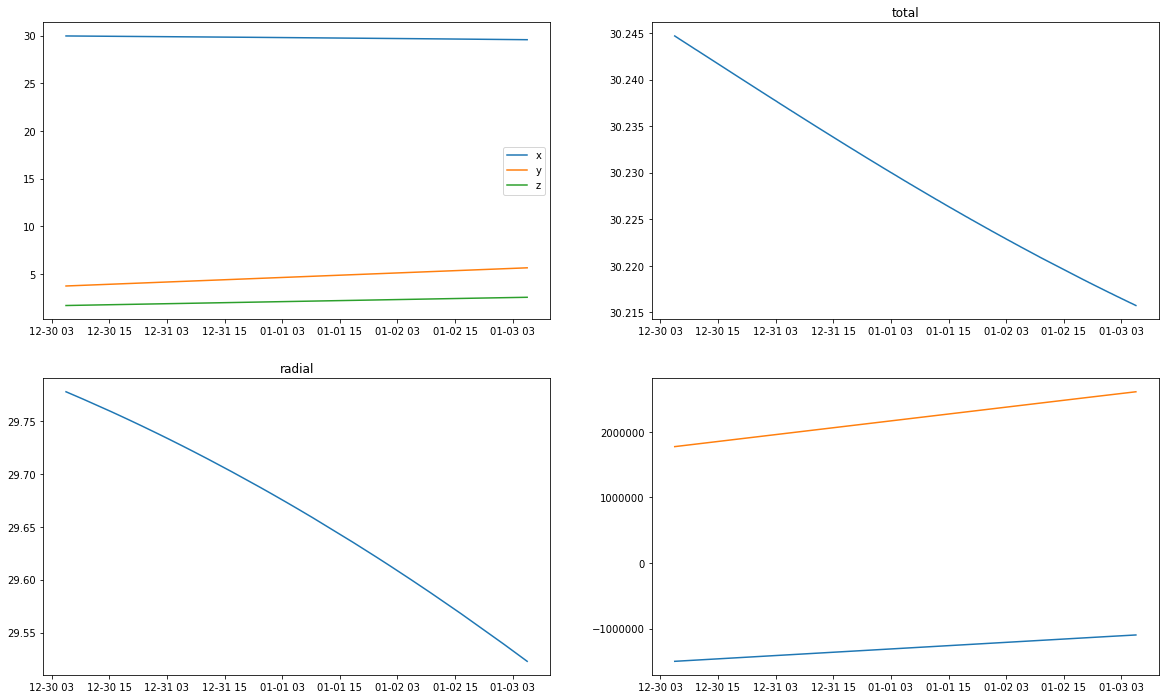

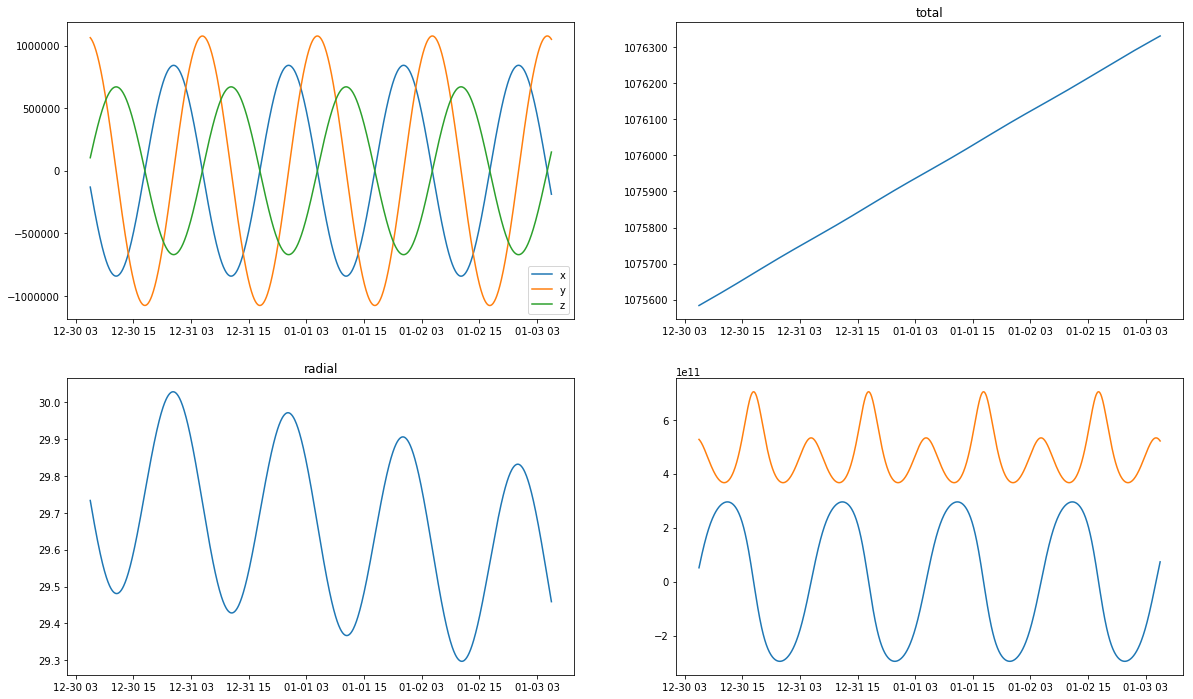

In [24]:
frame_transform_graph.get_transform(CIRS, AltAz).transforms[0].finite_difference_dt = 1*u.second

time = Time('J2015') + np.linspace(-2,2,1200)*u.day
loc = EarthLocation.of_site('greenwich')  #built-in
aa = AltAz(obstime=time, location=loc)
print("AA1")
diff_info_plot(i.transform_to(aa), time)


c = i.transform_to(CIRS(obstime=time))
a = c.transform_to(aa)

print('CIRS')
diff_info_plot(c, time)
print('AA2')
diff_info_plot(a, time)
None

AA1
initial [[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]] km / s
induced [[ 29.96287085  29.96260086  29.96232661 ...,  29.57135622  29.57097355
   29.57059089]
 [  3.7503692    3.75196161   3.75356714 ...,   5.65244467   5.65401499
    5.65558534]
 [  1.70358705   1.70432049   1.70505234 ...,   2.56491795   2.56560569
    2.56629714]] km / s
initial [[ 24.68005787  24.66425005  24.63806592 ...,  25.14922536  25.15198227
   25.14438904]
 [  0.67187266   1.30460322   1.93674374 ...,  -0.4613844    0.1697895
    0.80088532]
 [-17.4695286  -17.45600598 -17.43422516 ..., -16.74209119 -16.74340581
  -16.73647625]] km / s
induced [[ -130222.91622102  -147615.87210171  -164943.63491039 ...,
   -152374.52304747  -169695.49698647  -186941.5236268 ]
 [ 1059507.19412497  1055775.48721479  1051577.36547879 ...,
   1055428.32069693  1051102.43999395  1046312.20995587]
 [  103667.92740183   117513.90003666   131307.97383492 ...,
    121302.12911389 

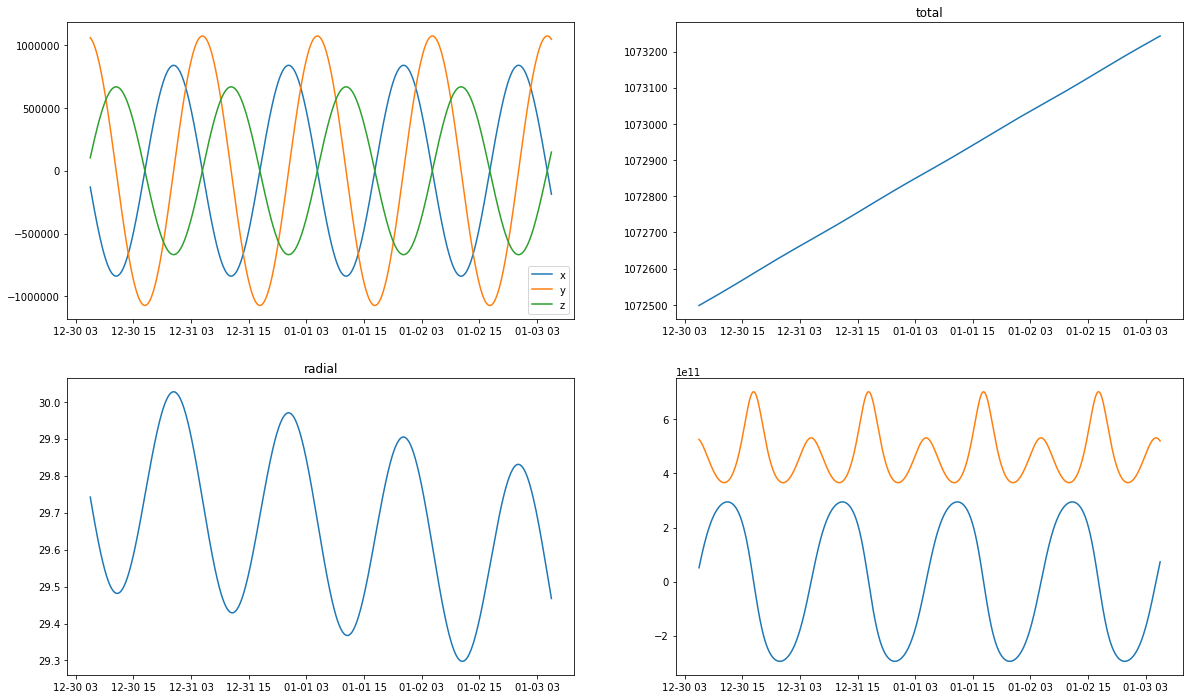

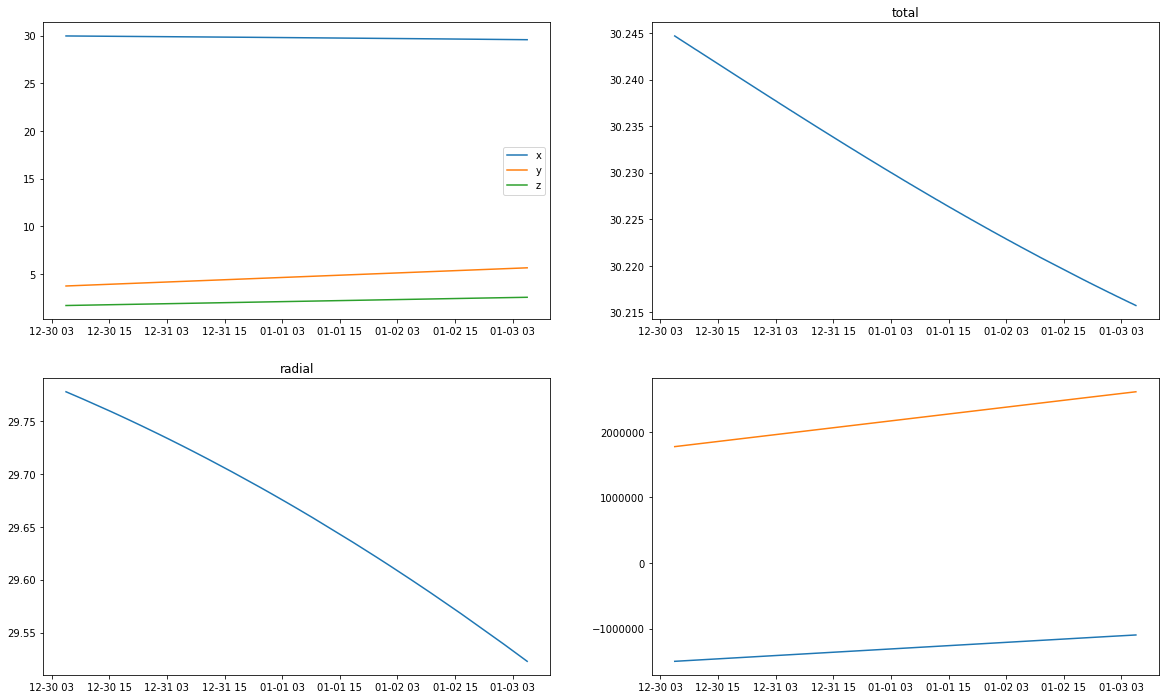

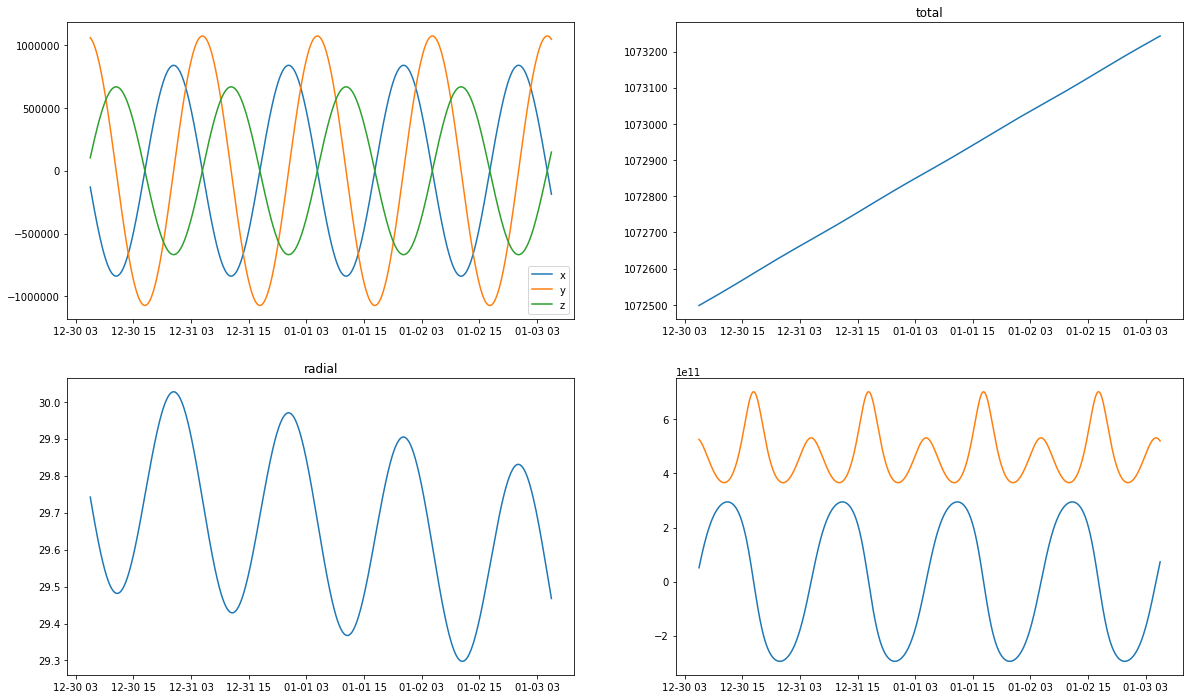

In [25]:
frame_transform_graph.get_transform(CIRS, AltAz).transforms[0].finite_difference_dt = 1*u.hr
time = Time('J2015') + np.linspace(-2,2,1200)*u.day
loc = EarthLocation.of_site('greenwich')  #built-in
aa = AltAz(obstime=time, location=loc)
print("AA1")
diff_info_plot(i.transform_to(aa), time)


c = i.transform_to(CIRS(obstime=time))
a = c.transform_to(aa)

print('CIRS')
diff_info_plot(c, time)
print('AA2')
diff_info_plot(a, time)
None